In [0]:
from google.colab import files
uploaded = files.upload()
!unzip df.zip

Saving df.zip to df.zip
Archive:  df.zip
  inflating: df.csv                  


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [0]:
df = pd.read_csv('df.csv',parse_dates=True,index_col='date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns=['Value']

In [0]:
df

,Value
date,
1993-01,7.021576e+05
1993-02,2.726925e+06
1993-03,4.730319e+06
1993-04,7.378368e+06
1993-05,1.168075e+07
...,...
1998-08,1.506393e+08
1998-09,1.482977e+08
1998-10,1.518896e+08


Equation for AR model : <br>
![alt text](https://i.stack.imgur.com/cj6yX.png)

In [0]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

In [0]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



In [0]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

<h1>
We break down the ARIMA Model into 3 steps:

1. Making the data stationary by differencing. (I)
2. Fitting an AR model. (AR)
3. Fitting an MA model on the residuals. (MA)
4. Getting Back Original data

</h1>

#Step 1 : Making the data stationary

Different techniques can be used to make the data stationary, used log and differencing. The additional diff(12) is remove the seasonality.

In [0]:
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(12))
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.225226609716364
p-value : 7.807176920050943e-06
Number of Lags Used : 3
Number of Observations Used : 55
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


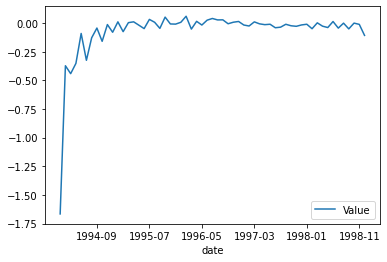

In [0]:
# print(df_testing.to_string())
df_testing.plot()

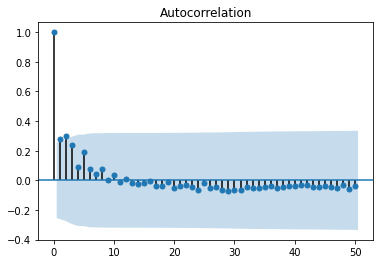

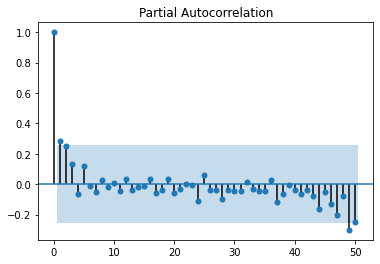

In [0]:
ACF = plot_acf(df_testing.dropna(),lags=50)
PACF = plot_pacf(df_testing.dropna(),lags=50)

#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [0]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Value))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

The RMSE is : 0.032388648408077265 , Value of p :  1
The RMSE is : 0.03325009798919134 , Value of p :  2
The RMSE is : 0.029558050939839802 , Value of p :  3
The RMSE is : 0.028285801000846898 , Value of p :  4
The RMSE is : 0.03151488059849384 , Value of p :  5
The RMSE is : 0.0322596083639379 , Value of p :  6
The RMSE is : 0.027590310611580772 , Value of p :  7
The RMSE is : 0.034671315188419 , Value of p :  8
The RMSE is : 0.030740362591167695 , Value of p :  9
The RMSE is : 0.03256948869494694 , Value of p :  10
The RMSE is : 0.031246634780044597 , Value of p :  11
The RMSE is : 0.03567977199974267 , Value of p :  12
The RMSE is : 0.031805101515395943 , Value of p :  13
The RMSE is : 0.03243678373356788 , Value of p :  14
The RMSE is : 0.048006580308367575 , Value of p :  15
The RMSE is : 0.060138095103115206 , Value of p :  16
The RMSE is : 0.05737216043431321 , Value of p :  17
The RMSE is : 0.11567845252209938 , Value of p :  18
The RMSE is : 0.1842163299370899 , Value of p :  

In [0]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

The RMSE is : 0.027590310611580772 , Value of p :  7


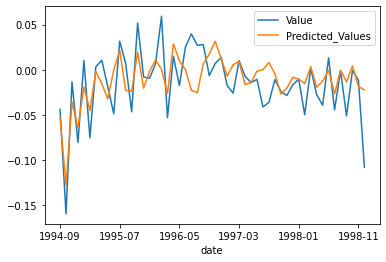

In [0]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()

Generating the residuals for MA

In [0]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

In [0]:
res

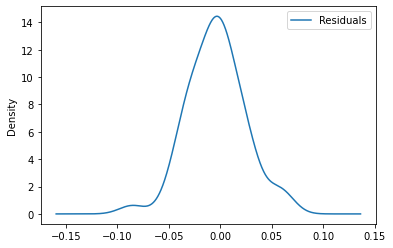

In [0]:
res.plot(kind='kde')

#Step 3 : Fitting MA on Residuals

The RMSE is : 0.031984021565677506 , Value of q :  1
The RMSE is : 0.032989430227765876 , Value of q :  2
The RMSE is : 0.03408338236742454 , Value of q :  3
The RMSE is : 0.03450430781256752 , Value of q :  4
The RMSE is : 0.035351319086375566 , Value of q :  5
The RMSE is : 0.035867081911430024 , Value of q :  6
The RMSE is : 0.03718574869751802 , Value of q :  7
The RMSE is : 0.037286951086643504 , Value of q :  8
The RMSE is : 0.038078751114832825 , Value of q :  9
The RMSE is : 0.03736485660629247 , Value of q :  10
The RMSE is : 0.037903042892427484 , Value of q :  11
The RMSE is : 0.04337445915271738 , Value of q :  12
1


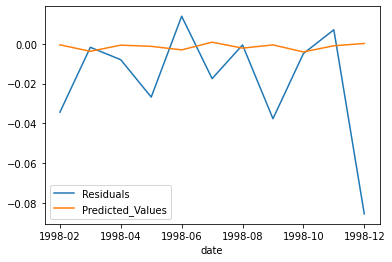

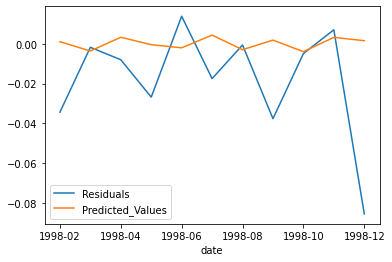

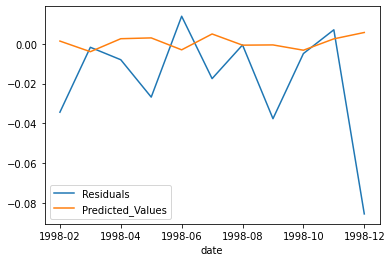

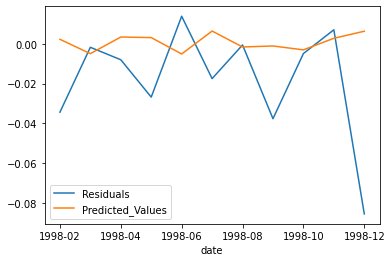

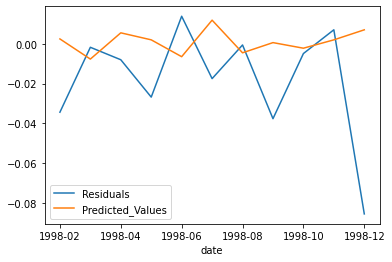

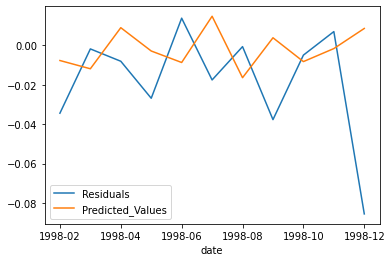

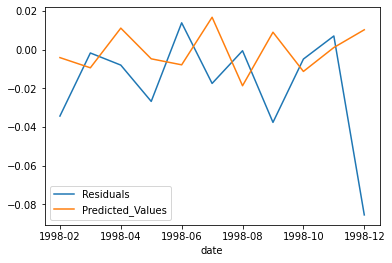

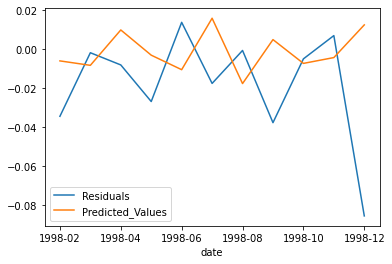

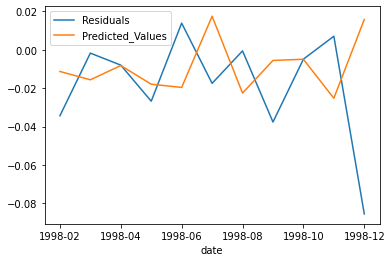

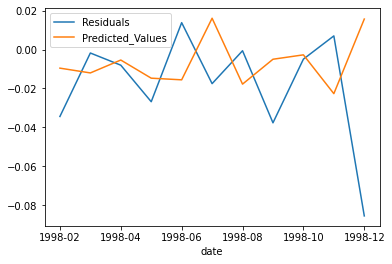

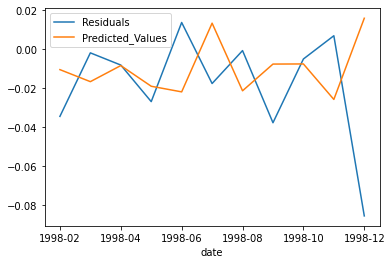

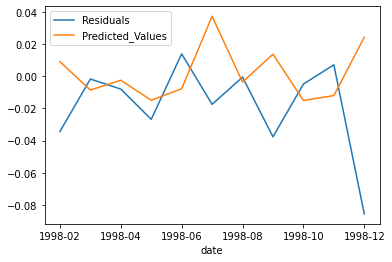

In [0]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 0.031984021565677506 , Value of q :  1
[[0.09510917]]
[-0.00053678]


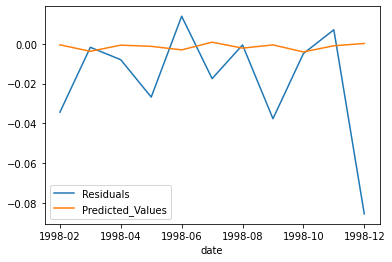

In [0]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [0]:
res_c = pd.concat([res_train,res_test])

In [0]:
res_c

,Residuals,Shifted_values_1,Predicted_Values
date,,,
1994-10,-0.031686,0.009048,0.000324
1994-11,0.022175,-0.031686,-0.003550
1994-12,-0.016185,0.022175,0.001572
1995-01,0.029131,-0.016185,-0.002076
1995-02,-0.030341,0.029131,0.002234
1995-03,0.005497,-0.030341,-0.003422
1995-04,0.025826,0.005497,-0.000014
1995-05,0.013401,0.025826,0.001919
1995-06,-0.048368,0.013401,0.000738


In [0]:
df_c.Predicted_Values += res_c.Predicted_Values

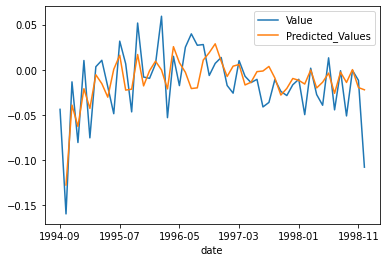

In [0]:
df_c[['Value','Predicted_Values']].plot()

# Step 4 : Getting Back Original data

Reversing the steps performed for differencing, as a check the first column (Value) must be the same after reversing the steps.

In [0]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value 
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [0]:
df_c

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Predicted_Values
date,,,,,,,,,
1994-09,4.647984e+07,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,-1.665408,NaN
1994-10,4.661549e+07,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,4.813179e+07
1994-11,4.759123e+07,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,4.638252e+07
1994-12,6.190363e+07,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,6.301268e+07
1995-01,6.624558e+07,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,6.421018e+07
1995-02,4.512608e+07,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,4.662025e+07
1995-03,5.411343e+07,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,5.363294e+07
1995-04,5.484414e+07,0.003420,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,5.344514e+07
1995-05,5.991497e+07,0.010533,0.003420,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,5.923097e+07


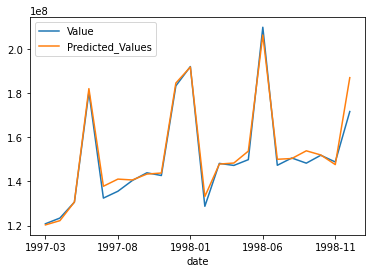

In [0]:
df_c.iloc[30:,:][['Value','Predicted_Values']].plot()